<a href="https://colab.research.google.com/github/safaabuzaid/xai-brain-tumor-classification/blob/main/02_DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import os
import hashlib
from PIL import Image
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_root = '/content/drive/MyDrive/Data/MRI_data'
train_root = f"{data_root}/Training"
test_root = f"{data_root}/Testing"

#1. Data Cleaning

### List classes from folder structure

In [ ]:
def list_subfolders(path):
  items = sorted ([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
  return items

train_classes = list_subfolders(train_root)
test_classes = list_subfolders(test_root)

print (f"Train classes: {train_classes}")
print (f"Test classes: {test_classes}")

Train classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Check for duplicate images using hashes

In [ ]:
def md5_of_file(path, block_size=65536): #block_size = 64 KB
  md5 = hashlib.md5()
  with open (path,'rb') as f:
    for block in iter (lambda: f.read(block_size),b''):
      md5.update(block)
    return md5.hexdigest()

def find_duplicates(root):
    hash_map = {}
    duplicates = []
    for cls in sorted(os.listdir(root)):
        cls_path = os.path.join(root, cls)
        if not os.path.isdir(cls_path): continue
        for fname in os.listdir(cls_path):
            fpath = os.path.join(cls_path, fname)
            try:
                h = md5_of_file(fpath)
            except Exception:
                continue
            if h in hash_map:
                duplicates.append((fpath, hash_map[h]))
            else:
                hash_map[h] = fpath
    return duplicates, hash_map

In [ ]:
train_dups, train_hash_map = find_duplicates(train_root)
test_dups, test_hash_map = find_duplicates(test_root)

In [ ]:
print (f"Train duplicates: {len(train_dups)}")
print (f"Test duplicates: {len(test_dups)}")

Train duplicates: 191
Test duplicates: 27


In [ ]:
#Review Duplicants

import pandas as pd

pd.DataFrame(train_dups, columns=["duplicate_file_path", "original_file_path"]).to_csv("duplicates_list.csv", index=False)

###Duplicate Detection and Cleaning
Checked for duplicate images in training and testing datasets using hash-based comparison.

**Results:**

- Training duplicates: 191
- Testing duplicates: 27

**Decision:** After manually reviewing a sample of duplicates, I found that most “duplicates” were not exact copies (e.g., flipped or slightly altered).

**Action:** Due to the high false-positive rate, **all images** were retained for model training.


#2. Data Preprocessing

### Image Enhancement

All images in the training and testing sets were processed through the following steps:

1.  **Resize Images:** Standardized all images to 224×224 pixels to be compatible with CNN models.
2.   **Color Correction:** Ensured all images have 3 channels (RGB) for consistent input.
3. **Intensity Normalization:** Scaled pixel values to 0–1 to reduce brightness variations across images.
4. **Contrast Enhancement (CLAHE):** Applied adaptive histogram equalization to improve visibility of features.
5. **Noise Reduction:** Used bilateral filtering to smooth background noise while preserving edges.
6. **Edge Enhancement & Sharpening:** Applied unsharp masking to emphasize tumor boundaries and structures.

**Advanced Techniques Used:**

- Bilateral filtering for edge-preserving denoising.

- CLAHE for adaptive local contrast enhancement.

- Unsharp masking for refined edge sharpening.








In [4]:
training_op_dir = "/content/drive/MyDrive/Data/MRI_data/data_preprocessed/Training"
classes = os.listdir(train_root)
for cls in classes:
  os.makedirs(os.path.join(training_op_dir, cls), exist_ok=True)

In [5]:
testing_op_dir = "/content/drive/MyDrive/Data/MRI_data/data_preprocessed/Testing"
classes = os.listdir(test_root)
for cls in classes:
  os.makedirs(os.path.join(testing_op_dir, cls), exist_ok=True)

In [6]:
def enhance_image(img_path, target_size=(224, 224)):
    # Load image
    img = cv2.imread(img_path)

    # 1. Resize
    img = cv2.resize(img, target_size)

    # 2. Convert to RGB (if needed)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 3. Intensity normalization (scale to 0-1)
    img = img / 255.0

    # Convert to 8-bit for CLAHE
    img_uint8 = np.uint8(img*255)

    # 4. CLAHE for each channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = np.zeros_like(img_uint8)
    for i in range(3):
        img_clahe[:,:,i] = clahe.apply(img_uint8[:,:,i])

    # 5. Noise reduction (bilateral filter)
    img_denoise = cv2.bilateralFilter(img_clahe, d=9, sigmaColor=75, sigmaSpace=75)

    # 6. Edge enhancement (unsharp mask)
    gaussian = cv2.GaussianBlur(img_denoise, (9,9), 10.0)
    img_sharp = cv2.addWeighted(img_denoise, 1.5, gaussian, -0.5, 0)

    # Return final image
    return img_sharp


In [7]:
for cls in classes:
    cls_input_path = os.path.join(train_root, cls)
    cls_output_path = os.path.join(training_op_dir, cls)

    for img_name in tqdm(os.listdir(cls_input_path), desc=f"Processing {cls}"):
        img_path = os.path.join(cls_input_path, img_name)
        enhanced_img = enhance_image(img_path)

        # Save the processed image
        save_path = os.path.join(cls_output_path, img_name)
        cv2.imwrite(save_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))

Processing pituitary: 100%|██████████| 1457/1457 [01:20<00:00, 18.08it/s]


In [8]:
for cls in classes:
    cls_input_path = os.path.join(test_root, cls)
    cls_output_path = os.path.join(testing_op_dir, cls)

    for img_name in tqdm(os.listdir(cls_input_path), desc=f"Processing {cls}"):
        img_path = os.path.join(cls_input_path, img_name)
        enhanced_img = enhance_image(img_path)

        # Save the processed image
        save_path = os.path.join(cls_output_path, img_name)
        cv2.imwrite(save_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))

Processing pituitary: 100%|██████████| 300/300 [00:13<00:00, 21.68it/s]


#### Output

Enhanced images are saved in the data_preprocessed folder with the same folder structure as the original dataset:

```
data_preprocessed/
    ├── training/
    │    ├── glioma/
    │    ├── meningioma/
    │    ├── pituitary/
    │    └── no_tumor/
    └── testing/
         ├── glioma/
         ├── meningioma/
         ├── pituitary/
         └── no_tumor/
```
This structure allows direct use with PyTorch’s ImageFolder data loader.



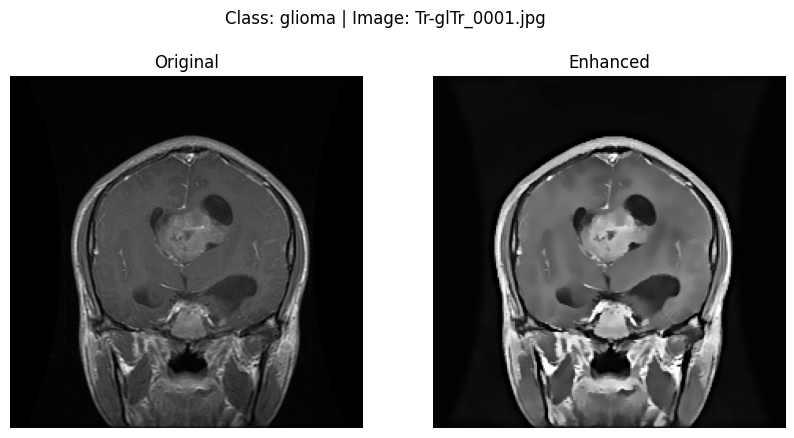

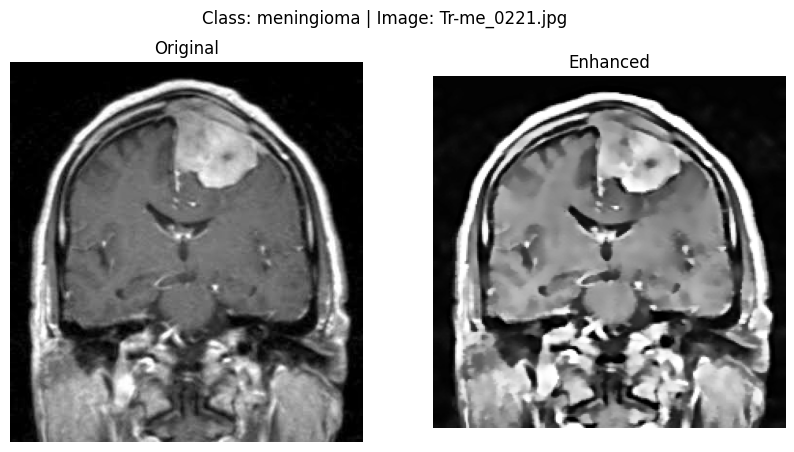

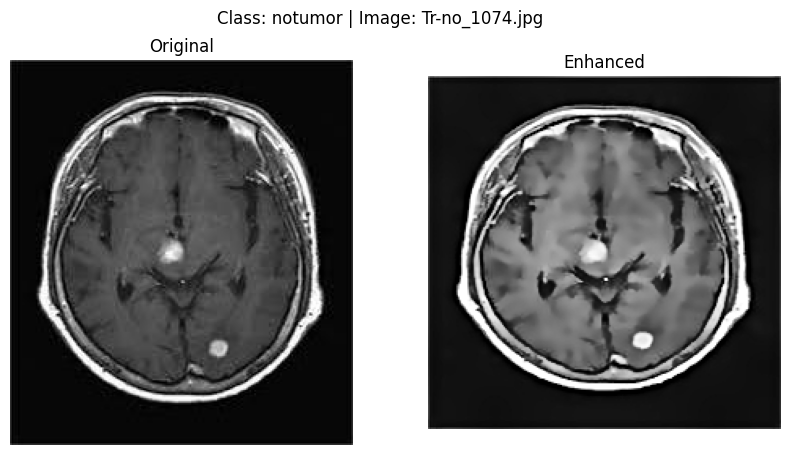

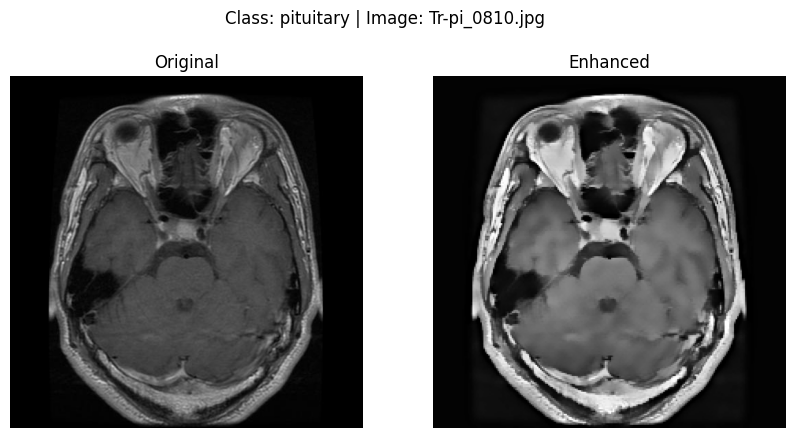

In [ ]:
# Pick a few random images to check
num_samples = 1

for cls in classes:
    cls_input_path = os.path.join(train_root, cls)
    img_names = os.listdir(cls_input_path)
    sample_imgs = random.sample(img_names, num_samples)

    for img_name in sample_imgs:
        img_path = os.path.join(cls_input_path, img_name)
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        img_enhanced = enhance_image(img_path)

        # Plot side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img_original)
        axes[0].set_title("Original")
        axes[0].axis('off')

        axes[1].imshow(img_enhanced)
        axes[1].set_title("Enhanced")
        axes[1].axis('off')

        plt.suptitle(f"Class: {cls} | Image: {img_name}")
        plt.show()


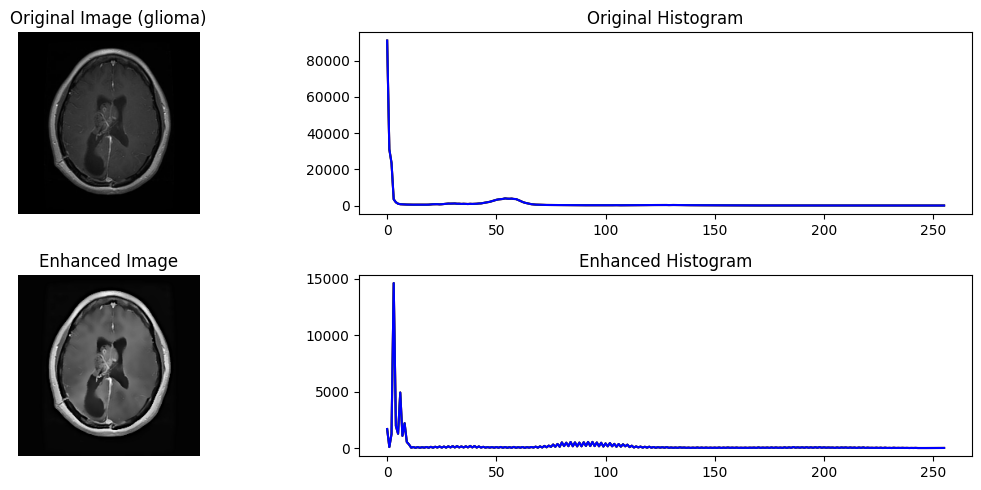

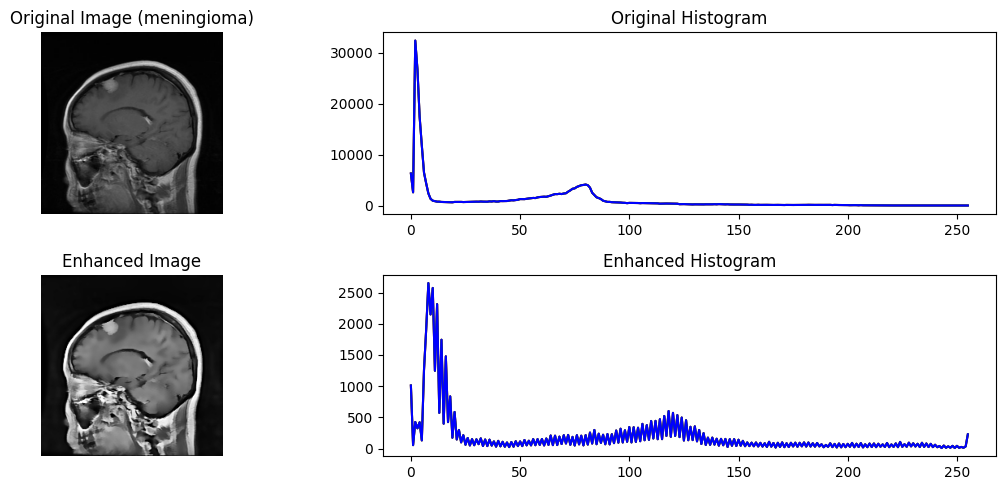

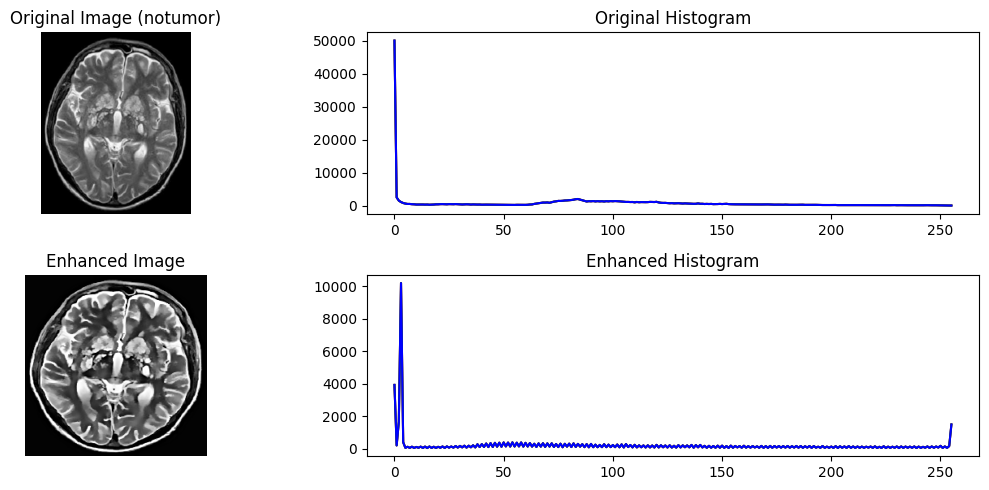

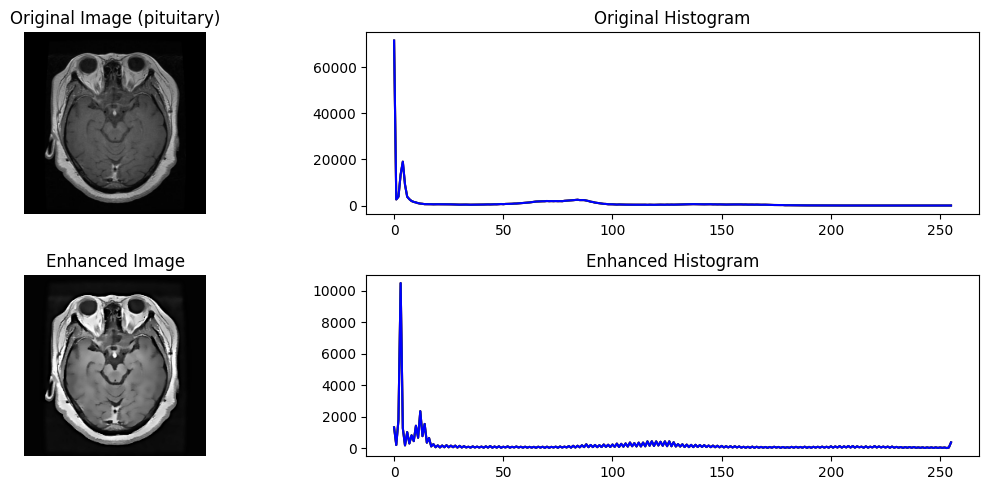

In [ ]:
# Pick one random image per class for histogram comparison
for cls in classes:
    cls_input_path = os.path.join(train_root, cls)
    img_names = os.listdir(cls_input_path)
    img_name = random.choice(img_names)
    img_path = os.path.join(cls_input_path, img_name)

    # Load original and enhanced images
    img_original = cv2.imread(img_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    img_enhanced = enhance_image(img_path)

    # Plot original image and histogram
    plt.figure(figsize=(12,5))

    plt.subplot(2,2,1)
    plt.imshow(img_original)
    plt.title(f"Original Image ({cls})")
    plt.axis('off')

    plt.subplot(2,2,2)
    for i, col in enumerate(['r','g','b']):
        hist = cv2.calcHist([img_original],[i],None,[256],[0,256])
        plt.plot(hist, color=col)
    plt.title("Original Histogram")

    # Plot enhanced image and histogram
    plt.subplot(2,2,3)
    plt.imshow(img_enhanced)
    plt.title("Enhanced Image")
    plt.axis('off')

    plt.subplot(2,2,4)
    for i, col in enumerate(['r','g','b']):
        hist = cv2.calcHist([img_enhanced],[i],None,[256],[0,256])
        plt.plot(hist, color=col)
    plt.title("Enhanced Histogram")

    plt.tight_layout()
    plt.show()


## Notes

- All preprocessing steps are deterministic and reproducible.

- This notebook does not include augmentation, which will be applied later in the training stage.

- The preprocessing ensures a high-quality, consistent dataset ready for deep learning experiments.